reference:  
[google bert](https://github.com/google-research/bert)  
[keras-bert-tpu](https://colab.research.google.com/github/HighCWu/keras-bert-tpu/blob/master/demo/load_model/load_and_predict.ipynb#scrollTo=GBFMypMHSHlt)  
[keras-bert](https://github.com/CyberZHG/keras-bert)  
[keras-bert jupyter notebook](https://github.com/strongio/keras-bert/blob/master/keras-bert.ipynb)


In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import os
UPLOAD_TIME = '2018_10_18' #@param {type:"string"}
BERT_MODEL = 'uncased_L-12_H-768_A-12' #@param {type:"string"}
download_url = 'https://storage.googleapis.com/bert_models/{}/{}.zip'.format(UPLOAD_TIME,BERT_MODEL)
zip_path = '{}.zip'.format(BERT_MODEL)
! test -d $BERT_MODEL || (wget $download_url && unzip $zip_path)
BERT_PRETRAINED_DIR = os.path.realpath(BERT_MODEL)
print('***** BERT pretrained directory: {} *****'.format(BERT_PRETRAINED_DIR))

--2019-04-28 03:13:08--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.111.128, 2607:f8b0:4001:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.111.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip’

uncased_L-12_H-768_ 100%[===================>] 388.84M   119MB/s    in 3.3s    

2019-04-28 03:13:11 (119 MB/s) - ‘uncased_L-12_H-768_A-12.zip’ saved [407727028/407727028]

Archive:  uncased_L-12_H-768_A-12.zip
   creating: uncased_L-12_H-768_A-12/
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: uncased_L-12_H-768_A-12/vocab.txt  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: uncased_L-12_H-768_A-12/bert_config.json  
***** BERT pr

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

!pip install -q tensorflow==1.13.1
!pip install -q bert-tensorflow
!pip install -q keras-bert

    100% |████████████████████████████████| 71kB 3.4MB/s 


In [0]:

import keras
from keras import backend as K
from keras import layers, models, optimizers, initializers
from keras import regularizers
import numpy as np
import csv
import os
import json
from bert.tokenization import FullTokenizer
from keras_bert.loader import load_trained_model_from_checkpoint
from keras_bert.bert import *
import pickle

In [0]:
data_path = "/content/drive/My Drive/"
#train_tweet_npz = data_path + "train_tweets.npz"
#train_tweet = np.load(train_tweet_npz)
#test_tweet_npz = data_path + "test_tweets.npz"
#test_tweet = np.load(test_tweet_npz)
#dev_tweet_npz = data_path + "dev_tweets.npz"
#dev_tweet = np.load(dev_tweet_npz)

In [0]:
def read_train(src_file: str):
    """Generates (id, tweet, dimension, score) tuples from the lines in an src file.

    :param src_file:
    :return:
    """
    id_list = list()
    tweet_list = list()
    # dimension_list = list()
    intensity_list = list()
    with open(src_file) as fp:
        reader = csv.DictReader(fp, delimiter='\t')
        for row in reader:
            record_id = row['ID']
            tweet = row['Tweet']
            dimension = row['Affect Dimension']
            if dimension != 'valence':
                print(record_id)
            intensity = (row['Intensity Class']).split(': ')[0]
            id_list.append(record_id)
            tweet_list.append(tweet)
            # dimension_list.append(dimension)
            intensity_list.append(intensity)

    return id_list, tweet_list, intensity_list


def read_test(src_file: str):
    """Generates (id, tweet, dimension, score) tuples from the lines in an src file.

    :param src_file:
    :return:
    """
    id_list = list()
    dimension_list = list()
    tweet_list = list()
    with open(src_file) as fp:
        reader = csv.DictReader(fp, delimiter='\t')
        for row in reader:
            record_id = row['ID']
            tweet = row['Tweet']
            dimension = row['Affect Dimension']
            if dimension != 'valence':
                print(record_id)
            id_list.append(record_id)
            dimension_list.append(dimension)
            tweet_list.append(tweet)

    return id_list, tweet_list


In [0]:
train_file = data_path + '2018-Valence-oc-En-train.txt'
test_file = data_path + '2018-Valence-oc-En-test.txt'
dev_file = data_path + '2018-Valence-oc-En-dev.txt'

vocab_file = data_path + 'vocab_emotion.txt'

train_id, train_tweet, intensity_list = read_train(train_file)
train_labels = [int(x) + 3 for x in intensity_list]

dev_id, dev_tweet, intensity_list = read_train(dev_file)
dev_labels = [int(x) + 3 for x in intensity_list]

test_id, test_tweet = read_test(test_file)


In [0]:
train_labels = np.reshape(np.vstack(train_labels), newshape=(-1))
dev_labels = np.reshape(np.vstack(dev_labels), newshape=(-1))
test_labels = np.zeros(len(test_id), dtype=int)

In [0]:
class PaddingInputExample(object):
    """Fake example so the num input examples is a multiple of the batch size.
  When running eval/predict on the TPU, we need to pad the number of examples
  to be a multiple of the batch size, because the TPU requires a fixed batch
  size. The alternative is to drop the last batch, which is bad because it means
  the entire output data won't be generated.
  We use this class instead of `None` because treating `None` as padding
  battches could cause silent errors.
  """

class InputExample(object):
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text_a, text_b=None, label=None):
        """Constructs a InputExample.
    Args:
      guid: Unique id for the example.
      text_a: string. The untokenized text of the first sequence. For single
        sequence tasks, only this sequence must be specified.
      text_b: (Optional) string. The untokenized text of the second sequence.
        Only must be specified for sequence pair tasks.
      label: (Optional) string. The label of the example. This should be
        specified for train and dev examples, but not for test examples.
    """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label

def create_tokenizer_from_hub_module():
    """Get the vocab file and casing info from the Hub module."""
    bert_module =  hub.Module(bert_path)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    vocab_file, do_lower_case = sess.run(
        [
            tokenization_info["vocab_file"],
            tokenization_info["do_lower_case"],
        ]
    )

    return FullTokenizer(vocab_file=vocab_file, do_lower_case=do_lower_case)

def convert_single_example(tokenizer, example, max_seq_length=256):
    """Converts a single `InputExample` into a single `InputFeatures`."""

    if isinstance(example, PaddingInputExample):
        input_ids = [0] * max_seq_length
        input_mask = [0] * max_seq_length
        segment_ids = [0] * max_seq_length
        label = 0
        return input_ids, input_mask, segment_ids, label

    tokens_a = tokenizer.tokenize(example.text_a)
    if len(tokens_a) > max_seq_length - 2:
        tokens_a = tokens_a[0 : (max_seq_length - 2)]

    tokens = []
    segment_ids = []
    tokens.append("[CLS]")
    segment_ids.append(0)
    for token in tokens_a:
        tokens.append(token)
        segment_ids.append(0)
    tokens.append("[SEP]")
    segment_ids.append(0)

    input_ids = tokenizer.convert_tokens_to_ids(tokens)

    # The mask has 1 for real tokens and 0 for padding tokens. Only real
    # tokens are attended to.
    input_mask = [1] * len(input_ids)

    # Zero-pad up to the sequence length.
    while len(input_ids) < max_seq_length:
        input_ids.append(0)
        input_mask.append(0)
        segment_ids.append(0)

    assert len(input_ids) == max_seq_length
    assert len(input_mask) == max_seq_length
    assert len(segment_ids) == max_seq_length

    return input_ids, input_mask, segment_ids, example.label

def convert_examples_to_features(tokenizer, examples, max_seq_length=256):
    """Convert a set of `InputExample`s to a list of `InputFeatures`."""

    input_ids, input_masks, segment_ids, labels = [], [], [], []
    for (ex_index, example) in enumerate(examples):
        input_id, input_mask, segment_id, label = convert_single_example(
            tokenizer, example, max_seq_length
        )
        input_ids.append(input_id)
        input_masks.append(input_mask)
        segment_ids.append(segment_id)
        labels.append(label)
    return (
        np.array(input_ids),
        np.array(input_masks),
        np.array(segment_ids),
        np.array(labels).reshape(-1, 1),
    )

def convert_text_to_examples(texts, labels):
    """Create InputExamples"""
    InputExamples = []
    for text, label in zip(texts, labels):
        InputExamples.append(
            InputExample(guid=None, text_a=" ".join(text), text_b=None, label=label)
        )
    return InputExamples

In [0]:
sequence_length = 128

# Instantiate tokenizer
tokenizer = FullTokenizer(vocab_file=vocab_file, do_lower_case=True)

# Convert data to InputExample format
train_examples = convert_text_to_examples(train_tweet, train_labels)
dev_examples = convert_text_to_examples(dev_tweet, dev_labels)

test_examples = convert_text_to_examples(test_tweet, test_labels)

# Convert to features
(train_input_ids, train_input_masks, train_segment_ids, train_labels 
) = convert_examples_to_features(tokenizer, train_examples, max_seq_length=sequence_length)
(dev_input_ids, dev_input_masks, dev_segment_ids, dev_labels
) = convert_examples_to_features(tokenizer, dev_examples, max_seq_length=sequence_length)

(test_input_ids, test_input_masks, test_segment_ids, test_labels
) = convert_examples_to_features(tokenizer, test_examples, max_seq_length=sequence_length)

In [0]:
config_file = os.path.join(BERT_PRETRAINED_DIR, 'bert_config.json')
checkpoint_file = os.path.join(BERT_PRETRAINED_DIR, 'bert_model.ckpt')
bert_model = load_trained_model_from_checkpoint(config_file, checkpoint_file, training=True, seq_len=sequence_length)

# bert_model.summary(line_length=120)

In [0]:
bert_output = bert_model.get_layer(name='Encoder-12-FeedForward-Norm').output


In [0]:
embedding_dim = 768
batch_size = 32
drop = 0.9

epochs = 100

In [63]:
############################
# use output of first token (CLS) for classification

squeezed = layers.Lambda(lambda x: K.squeeze(x[:, 0:1, :], axis=1))(bert_output)
#reshape_data = layers.Reshape((sequence_length, embedding_dim, 1))(bert_output)


#dense1 = layers.Dense(units=128, activation='relu',
#                        kernel_initializer='glorot_uniform', 
#                        kernel_regularizer=regularizers.l2(0.06))(squeezed)

#dropout = layers.Dropout(drop)(dense1)
output = layers.Dense(units=7, activation='softmax', 
                      kernel_initializer=initializers.truncated_normal(stddev=0.02)
                      )(squeezed)

# this creates a model that includes
model = models.Model(inputs=bert_model.inputs, outputs=output)

opt = optimizers.Adam(lr=1e-4)##, decay=1e-6)
#opt = optimizers.SGD(lr=1e-4)

model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input-Token (InputLayer)        (None, 128)          0                                            
__________________________________________________________________________________________________
Input-Segment (InputLayer)      (None, 128)          0                                            
__________________________________________________________________________________________________
Embedding-Token (TokenEmbedding [(None, 128, 768), ( 23440896    Input-Token[0][0]                
__________________________________________________________________________________________________
Embedding-Segment (Embedding)   (None, 128, 768)     1536        Input-Segment[0][0]              
__________________________________________________________________________________________________
Embedding-

In [0]:
history = model.fit(
    [train_input_ids, train_input_masks, train_segment_ids], 
    train_labels,
    validation_data=([dev_input_ids, dev_input_masks, dev_segment_ids], dev_labels),
    epochs=100,
    batch_size=32
)

Train on 1181 samples, validate on 449 samples
Epoch 1/100
 192/1181 [===>..........................] - ETA: 2:27 - loss: 1.8667 - acc: 0.2760

In [0]:
# save the trials object
with open(save_file, "wb") as f:
    pickle.dump(history.history, f)

In [60]:
filter_sizes = [2,3,4]
num_filters = 256

#############################
## build text cnn model
#############################

nomask = layers.Lambda(lambda x: x, output_shape=lambda s:s)(bert_output)
reshape_data = layers.Reshape((sequence_length, embedding_dim, 1))(nomask)

pooled_outputs = []
for i, filter_size in enumerate(filter_sizes):
    conv_layer = layers.Conv2D(num_filters, 
                               kernel_size=(filter_sizes[i], embedding_dim), 
                               padding='valid', 
                               kernel_initializer='glorot_uniform', 
                               kernel_regularizer=regularizers.l2(0.1), activation='relu')(reshape_data)
    bn_layer = layers.BatchNormalization()(conv_layer)
    pool_layer = layers.MaxPool2D(pool_size=(sequence_length - filter_sizes[i] + 1, 1), strides=(1,1), padding='valid')(bn_layer)
    pooled_outputs.append(pool_layer)

concatenated_tensor = layers.Concatenate(axis=1)(pooled_outputs)
flatten = layers.Flatten()(concatenated_tensor)
#flatten1 = layers.Dense(units=128, activation='relu',
#                        kernel_initializer=initializers.truncated_normal(stddev=0.02), 
#                        kernel_regularizer=regularizers.l2(0.1))(flatten)

dropout = layers.Dropout(drop)(flatten)
output = layers.Dense(units=7, activation='softmax', 
                      kernel_initializer=initializers.truncated_normal(stddev=0.02), 
                      kernel_regularizer=regularizers.l2(0.1))(dropout)

# this creates a model that includes
model = models.Model(inputs=bert_model.inputs, outputs=output)

opt = optimizers.Adam(lr=1e-5, decay=1e-6)
#opt = optimizers.SGD(lr=1e-4)

model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input-Token (InputLayer)        (None, 128)          0                                            
__________________________________________________________________________________________________
Input-Segment (InputLayer)      (None, 128)          0                                            
__________________________________________________________________________________________________
Embedding-Token (TokenEmbedding [(None, 128, 768), ( 23440896    Input-Token[0][0]                
__________________________________________________________________________________________________
Embedding-Segment (Embedding)   (None, 128, 768)     1536        Input-Segment[0][0]              
__________________________________________________________________________________________________
Embedding-

In [0]:
print("train model ==============================")
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_dev, y_dev))  # starts training

train model ==============================
Train on 1181 samples, validate on 449 samples
Epoch 1/100
1181/1181 [==============================] - 5s 4ms/sample - loss: 20.0445 - acc: 0.1702 - val_loss: 16.4608 - val_acc: 0.2249
Epoch 2/100
1181/1181 [==============================] - 4s 3ms/sample - loss: 16.9835 - acc: 0.2227 - val_loss: 16.4380 - val_acc: 0.2160
Epoch 3/100
1181/1181 [==============================] - 4s 3ms/sample - loss: 16.4276 - acc: 0.2371 - val_loss: 16.4046 - val_acc: 0.2227
Epoch 4/100
1181/1181 [==============================] - 4s 3ms/sample - loss: 16.2265 - acc: 0.3158 - val_loss: 16.3665 - val_acc: 0.2405
Epoch 5/100
1181/1181 [==============================] - 4s 3ms/sample - loss: 16.1231 - acc: 0.3311 - val_loss: 16.3278 - val_acc: 0.2517
Epoch 6/100
1181/1181 [==============================] - 4s 3ms/sample - loss: 16.0404 - acc: 0.3412 - val_loss: 16.2887 - val_acc: 0.2539
Epoch 7/100
1181/1181 [==============================] - 4s 3ms/sample - los

In [0]:
test_results_file = data_path + 'test_results.txt'
y_pred = model.predict(x=x_test)
np.savetxt(test_results_file, y_pred)

In [0]:
import matplotlib.pyplot as plt
plt.figure(figsize=(800,800))
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Dev'], loc='upper left')
plt.show()

In [0]:
plt.figure(figsize=(800,800))

<Figure size 57600x57600 with 0 Axes>

<Figure size 57600x57600 with 0 Axes>

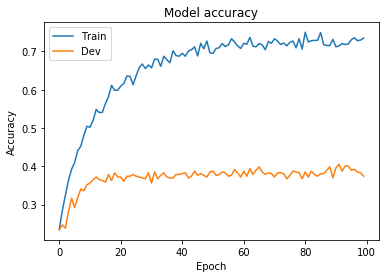

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Dev'], loc='upper left')
plt.show()